In [1]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.models as models
from torchvision.utils import save_image
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from model import ResNeXt, Discriminator
from dataloader import get_dataloaders
from ssim import ssim
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'


# Seed
manual_seed = 0
random.seed(manual_seed)
torch.manual_seed(manual_seed)

# Hyperparameters
lr = 0.0002
num_epochs = 1000
device = torch.device("cuda")
lambda_content = 1
lambda_texture = 0.5
lambda_tv = 0.01
batch_size = 64
sample_size = 50000

# Dataloaders
train_dataloader, test_dataloader = get_dataloaders(batch_size=batch_size, sample_size=sample_size)

# Initialize models
generator = ResNeXt().to(device)
discriminator = Discriminator().to(device)

# Initialize optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Loss functions
criterion_content = nn.MSELoss()
criterion_D = nn.BCELoss()

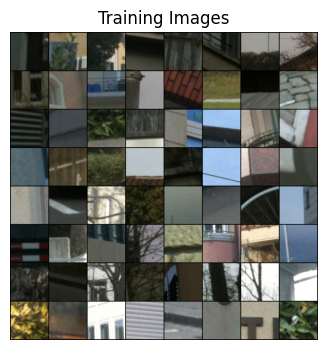

In [2]:
phone, dslr = next(iter(train_dataloader))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
# display the images with shape of torch.Size([3, 100, 100, 32])
plt.imshow(np.transpose(vutils.make_grid(phone), (1,2,0)))

In [3]:
# # Load the generator checkpoint
# checkpoint_G = torch.load(f'checkpoints/generator_epoch_{start_epoch}.pth')
# generator.load_state_dict(checkpoint_G)

# # Load the discriminator checkpoint
# checkpoint_D = torch.load('checkpoints/discriminator_epoch_94.pth')
# discriminator.load_state_dict(checkpoint_D)
# # Initialize optimizers
# optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
# optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [4]:

gen_losses = []
disc_losses = []
start_epoch = 1

# Load a pre-trained VGG model
vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features.to(device).eval()

def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', 
                  '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}
    features = {}
    for name, layer in model._modules.items():
        image = layer(image)
        if name in layers:
            features[layers[name]] = image
    return features

def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, -1)  # Change here
    gram = torch.mm(tensor, tensor.t())
    return gram / (tensor.size(1))

def total_variation_loss(img):
    tv_h = torch.mean(torch.abs(img[:, :, 1:, :] - img[:, :, :-1, :]))
    tv_w = torch.mean(torch.abs(img[:, :, :, 1:] - img[:, :, :, :-1]))
    return tv_h + tv_w



for epoch in range(start_epoch, num_epochs):
    for i, (phone_images, dslr_images) in enumerate(train_dataloader):

        phone_images, dslr_images = phone_images.to(device), dslr_images.to(device)
        current_batch_size = phone_images.size(0)

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Generate a batch of images
        enhanced_images = generator(phone_images)

        # Content loss
        content_loss = criterion_content(enhanced_images, dslr_images)

        # Texture loss
        enhanced_features = get_features(enhanced_images, vgg)
        dslr_features = get_features(dslr_images, vgg)
        texture_loss = 0
        for layer in enhanced_features:
            gram_enhanced = gram_matrix(enhanced_features[layer])
            gram_dslr = gram_matrix(dslr_features[layer])
            texture_loss += F.mse_loss(gram_enhanced, gram_dslr)

        # Total variation loss
        tv_loss = total_variation_loss(enhanced_images)

        # Combine losses
        total_gen_loss = content_loss + lambda_texture * texture_loss + lambda_tv * tv_loss
        total_gen_loss.backward()

        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        outputs_real = discriminator(dslr_images)

        # Adjust the label size to match the current batch size
        real_labels = torch.ones(current_batch_size, 1).to(device)
        fake_labels = torch.zeros(current_batch_size, 1).to(device)
   
        # Discriminator loss for real images
        loss_disc_real = criterion_D(outputs_real, real_labels)

        # Discriminator loss for fake (generated) images
        outputs_fake = discriminator(enhanced_images.detach())
        loss_disc_fake = criterion_D(outputs_fake, fake_labels)

        # Total discriminator loss
        total_disc_loss = (loss_disc_real + loss_disc_fake) / 2
        total_disc_loss.backward()
        optimizer_D.step()


        if (i+1) % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], "
                f"Gen Loss: {total_gen_loss.item()}, Disc Loss: {total_disc_loss.item()}")

            # Save model checkpoints
            torch.save(generator.state_dict(), f'checkpoints/generator_epoch_{epoch}.pth')
            torch.save(discriminator.state_dict(), f'checkpoints/discriminator_epoch_{epoch}.pth')

            # Example of saving a sample enhanced image
            sample_enhanced = enhanced_images[0]
            sample_original = phone_images[0]
            comparison = torch.cat((sample_original, sample_enhanced), dim=2)
            save_image(comparison, os.path.join('results', f'sample_epoch_{epoch}.jpg'))

        gen_losses.append(total_gen_loss.item())
        disc_losses.append(total_disc_loss.item())


c:\Users\cobra\.virtualenvs\DSLR-ResNeXt-sCYE6uU5\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/1000], Step [10/782], Gen Loss: 1.5280855894088745, Disc Loss: 0.24283285439014435
Epoch [1/1000], Step [20/782], Gen Loss: 0.43573132157325745, Disc Loss: 0.02490825578570366
Epoch [1/1000], Step [30/782], Gen Loss: 0.4374185800552368, Disc Loss: 0.011997794732451439
Epoch [1/1000], Step [40/782], Gen Loss: 0.3897372782230377, Disc Loss: 0.00548403337597847
Epoch [1/1000], Step [50/782], Gen Loss: 0.33478012681007385, Disc Loss: 0.0037011224776506424
Epoch [1/1000], Step [60/782], Gen Loss: 0.3802753686904907, Disc Loss: 0.002713908674195409
Epoch [1/1000], Step [70/782], Gen Loss: 0.3207475244998932, Disc Loss: 0.002244669245555997
Epoch [1/1000], Step [80/782], Gen Loss: 0.2815105617046356, Disc Loss: 0.0016525012906640768
Epoch [1/1000], Step [90/782], Gen Loss: 0.2956344187259674, Disc Loss: 0.0014833956956863403
Epoch [1/1000], Step [100/782], Gen Loss: 0.2585832178592682, Disc Loss: 0.0009843206498771906
Epoch [1/1000], Step [110/782], Gen Loss: 0.256754606962204, Disc 

In [ ]:

# Plot the generator and discriminator losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(gen_losses,label="G")
plt.plot(disc_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()




In [ ]:
# Save the model
torch.save({
    'epoch': epoch,
    'model_state_dict': generator.state_dict(),
    'optimizer_state_dict': optimizer_G.state_dict(),
    'loss': g_loss,
}, f"generator_epoch_{epoch}.pth")


NameError: name 'g_loss' is not defined

In [ ]:
checkpoint = torch.load("generator_epoch_49.pth")
generator.load_state_dict(checkpoint['model_state_dict'])
optimizer_G.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']


In [ ]:
from torchvision.utils import save_image
generator.eval()
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        imgs_iphone, imgs_dslr = data
        imgs_iphone, imgs_dslr = imgs_iphone.to(device), imgs_dslr.to(device)
        gen_imgs = generator(imgs_iphone)
        
        save_image(gen_imgs, f"images/image_{i}.jpg")
